# Title: Probabilistic Energy Demand Forecasting Pipeline Walkthrough
### Author: Tobias Butler

<br>

# Description

This notebook is meant to serve as a walkthrough for the Energy Demand Forecasting Pipeline Project. It details how to use each of the three Python modules included in order to obtain a dataset, process it, and use it to fit a probabilistic forecasting model. This notebook does not outline how to run or access the interactive web-based application as that portion of the project is still under development. In the following cell, all necessary libraries and project modules are imported.

### Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import os
import itertools
import warnings
import random
import pickle as pkl
from IPython.display import Image
from scipy.stats import wilcoxon

# exporting plotly figures to html not working correctly
import plotly.io as pio
pio.renderers.default='notebook'

# import custom module
import preprocessing as pp
import model_definitions as md

# prevent logging when fitting Prophet models
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

# Loading The Data

The first component of this project works to download and compile data from the U.S. Energy Information Agency (EIA), the U.S. National Oceanic and Atmospheric Agency (NOAA), and the U.S. Bereua of Labor Statistics (BLS). This data includes hourly residential energy demand (in MWH) in New York City, along with monthly energy prices, hourly weather-related data from the Central Park station in New York, and monthly economic indicators for New York City. 

The Python module "get_data.py" contains all of the functionality to retrieve and compile this data. The functions within this Python module can be called individually or as a sequence by simply running the module as a script and providing the Python executable with a few arguments, including start date, end date, and an api key. Functions within the module look for an api key in the local directory by default, but I include one here for simplicity. Care should be taken not to share this key unless necessary as it could become deactivated if overused.

In the following cell, I run the "get_data.py" module and obtain a dataset in the local directory called "preliminary.csv".

<br>

### Compile Data From EIA, NOAA, and BLS

In [2]:
%run get_data.py "2018-06-19" "2024-03-01" "2eMANbsIGfgiA0uD42AeM7vo7EjbjGPgoGucnp5S"
# run python script to load data and save to Datasets/prelim.csv

Requesting energy demand data from EIA over 11 requests
Requesting energy price data from EIA
Requesting Weather Data from NOAA
Requesting data from Bereau of Labor Statistics
All data loaded successfully. Saving preliminary dataset to Saved/Datasets/preliminary.csv
Preliminary dataset saved.


### Preliminary Dataset Summary

To see that the python module has run successfully, I can load the dataset and display a summary of its characteristics.

In [3]:
# display summary of dataset
preliminary_data = pd.read_csv(r"Saved/Datasets/preliminary.csv", index_col=0)
desciptions = preliminary_data.describe().round(2)
cols_per_table = 6
for n in range(0,int(np.ceil(desciptions.shape[1]/cols_per_table))):
    # print(n*cols_per_table, (n*cols_per_table)+cols_per_table)
    display(desciptions.iloc[:,n*cols_per_table : (n*cols_per_table)+cols_per_table])

Energy Demand (MWH)  HourlyDewPointTemperature  \
count             49963.00                   47372.00   
mean               5706.07                      43.11   
std                1221.64                      19.12   
min                   0.00                     -17.00   
25%                4816.00                      28.00   
50%                5544.00                      45.00   
75%                6278.00                      60.00   
max               11069.00                      79.00   

       HourlyDryBulbTemperature  HourlyPrecipitation  HourlyRelativeHumidity  \
count                  47381.00             44674.00                47372.00   
mean                      57.21                 0.01                   62.31   
std                       16.84                 0.05                   19.59   
min                        2.00                 0.00                    7.00   
25%                       44.00                 0.00                   47.00   
50%                       58.00                 0.00                   61.00   
75%                       72.00                 0.00                   78.00   
max                       95.00                 3.47                  100.00   

       HourlyStationPressure  
count               47171.00  
mean                   29.88  
std                     0.23  
min                    28.71  
25%                    29.73  
50%                    29.88  
75%                    30.04  
max                    30.59

HourlyWetBulbTemperature  HourlyWindSpeed  Energy Price (cents/KWH)  \
count                  47145.00         40215.00                  48523.00   
mean                      50.52             4.99                     19.88   
std                       15.63            19.62                      1.97   
min                        0.00             0.00                     16.85   
25%                       38.00             3.00                     18.38   
50%                       51.00             5.00                     19.29   
75%                       64.00             7.00                     21.64   
max                       81.00          2237.00                     23.95   

          CPI-U  Unemployment Rate  Unemployment Level  
count  49266.00           48523.00            48523.00  
mean     295.43               7.16           293876.86  
std       17.72               4.01           157900.08  
min      273.84               3.30           141889.00  
25%      279.47               4.30           183976.00  
50%      289.49               5.30           221838.00  
75%      313.88              10.00           413107.00  
max      328.01              21.60           837338.00

Employment Level  Labor Force Level  Employment Population Ratio  \
count          48523.00           48523.00                     48523.00   
mean         3852615.99         4146492.86                        55.52   
std           239499.26          102864.29                         3.52   
min          3045001.00         3703849.00                        42.80   
25%          3697887.00         4083122.00                        53.90   
50%          3903360.00         4127193.00                        57.20   
75%          4069873.00         4249887.00                        57.70   
max          4137830.00         4318409.00                        58.60   

       Labor Force Participation  Civilian Noninstitutional Population  \
count                   48523.00                              48523.00   
mean                       59.76                            6940619.34   
std                         1.59                             149628.01   
min                        52.00                            6736242.00   
25%                        59.50                            6784151.00   
50%                        60.00                            6935936.00   
75%                        60.50                            7107053.00   
max                        61.80                            7119864.00   

       Payroll Employment  
count            48523.00  
mean              4465.78  
std                260.26  
min               3748.60  
25%               4225.70  
50%               4563.10  
75%               4661.90  
max               4756.70

<br>

### Reducing the Dataset

The dataset contains 18 variables, not including its datetime index. Many of these variables are highly correlated with each other and simalarly correlated with the dependent variable of interest, *Energy Demand (MWH)*. In order to simplify the rest of this walkthrough a bit (and reduce computation times), I will select a subset of the variables and use only those throughout the rest of the pipeline. I have not yet conducted a thorough analysis of the impacts from including and excluding different variables from the dataset on the predictive performance of the final forecasting model.

In [4]:
variables_considered = ["Energy Demand (MWH)", "HourlyDryBulbTemperature", 
    "HourlyPrecipitation", "HourlyWindSpeed", "Energy Price (cents/KWH)", 
    "Civilian Noninstitutional Population", "CPI-U"]
preliminary_dataset = preliminary_data[variables_considered]

<br>

# Data Processing and Cleaning

The second component of this project is a processing pipeline which works to clean the preliminary dataset by transforming select numerical variables to categorical ones, by identifying outliers using moving average estimation, and by imputing values for those outliers and other missing values using Prophet forecasting models and interpolation. All of this functionality, along with methods to create exploratory data analysis visualizations for a web application, are contained within the *PreprocessingPipeline* class defined in the "preprocessing.py" Python module. This module does not yet have the capacity to run as a script, but it can be used by creating an instance of the class and calling *process_data* as shown below.

In [5]:
# instantiate processing class
processor = pp.PreprocessingPipeline(saved_directory_name="Saved", produce_eda_plots=True)

In [6]:
# run processing pipeline, generating eda visuals along the way
warnings.filterwarnings('ignore', category=UserWarning) # prevents warnings from Seaborn library
clean_training_data, residuals = processor.process_dataset(preliminary_dataset=preliminary_dataset, split_into_train_holdout=True)
warnings.resetwarnings()

/home/tobi/Desktop/Capstone/EnergyDemandForecasting/preprocessing.py:724: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Interpolating for variable Energy Demand (MWH)
Interpolating for variable HourlyDryBulbTemperature
Interpolating for variable HourlyWindSpeed
Interpolating for variable Energy Price (cents/KWH)
Interpolating for variable Civilian Noninstitutional Population
Interpolating for variable CPI-U
Interpolating for variable HourlyPrecipitation


/home/tobi/Desktop/Capstone/EnergyDemandForecasting/preprocessing.py:500: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<br>

The argument *saved_directory_name* specifies the name of a directory that will be created in the current working directory. Having a local directory to save files to is a necessary part of the project currently, as it allows one to save the processed dataset, forecasting models, and visuals that will be used later by the graphical user interface for the application. The argument *produce_eda_plots* determines whether visualizations are created and saved that help describe the exploratory data analysis which was conducted to better understand the dataset.

# Instantiating and Tuning the Forecasting Model

The third component of the project pipeline focuses on creating a probabilistic forecasting model. A *Forecaster* class has been defined in the "model_definitions.py" module. This class contains methods that can be used to fit a probablisitic forecasting model to the clean time series dataset derived previously and use it to make predictions. It also contains some hyperparameter tuning functionality. In the following code cell, we create an instance of this *Forecaster* class.

In [7]:
model = md.Forecaster()

<br>

The *Forecaster* class, when fit, combines fourier transform-based Prophet models with vector autoregressive (VAR) models. It is probabilistic because it has underlying Prophet and VAR models that are trained to make point forecasts and to forecast the variance associated with every point forecast. When combined, the point forecasts and variance forecasts described a normally distributed prediction interval from which confidence intervals can be estimated. The *Forecaster* class contains a number of hyperparameters that can be tuned using the *tune_hyperparamters* method, as shown below. This method currently conducts a grid-search style hyperparamter tuning algorithm and should be used whenever the training data has undergone significant changes or updates.

In [54]:
# define hyperparameter sets
hyperparameter_sets = dict(changepoint_prior_scale=[0.001], seasonality_prior_scale=[0.01], 
    point_var_lags=[10], minimum_error_prediction=[100, 500, None], error_trend=[1e-2, 1e-1, 1, 10])

# Generate all possible combinations of values
keys = hyperparameter_sets.keys()
values = hyperparameter_sets.values()
combinations = itertools.product(*values)

# Create a list of dictionaries with all combinations
hyperparameter_sets = [dict(zip(keys, vals)) for vals in combinations]

# run grid-search hyperparameter tuning using 5-fold rolling cross-validation
hyperparameter_results = model.tune_hyperparameters(clean_training_data=clean_training_data, 
    dependent_variable="Energy Demand (MWH)", hyperparameter_sets=hyperparameter_sets, num_cv_folds=5)

In [64]:
# get best set of hyperparameters
wmses = [x[2] for x in hyperparameter_results]
best_set = hyperparameter_results[np.argmin(wmses)][0]
print(best_set)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'point_var_lags': 10, 'minimum_error_prediction': 100, 'error_trend': 10}


In [8]:
best_set = {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'point_var_lags': 10, 'minimum_error_prediction': 100, 'error_trend': 10}

<br>

The *tune_hyperparameters* function relies on the *cross_validate* function that is designed to run a K-folds rolling window cross validation function. This method is currently defined to calculate the average MSE and weighted MSE metrics over the K folds. Below, we show an example of the function run on the optimal hyperparameter set identified above.

### Cross Validate with Best Set of Hyperparameters

In [9]:
mse, wmse = model.cross_validate(num_folds=5, clean_training_data=clean_training_data, 
    dependent_variable="Energy Demand (MWH)", hyperparameters=best_set)

display(mse, wmse)

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/sklearn/utils/validation.py:605: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/sklearn/utils/validation.py:614: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-pa

1864836.9447689205

1862166.3143238954

<br>

### Fit the Final Model

To actually fit the model with a specific set of hyperparameters, one can use the *fit* function. This will trigger several other methods to run that fit the necessary Prophet and VAR models on the given training data using the provided set of hyperparameters. The dependent variable needs to be specified and is set to be *Energy Demand (MWH)* in the example below.

In [44]:
warnings.filterwarnings('ignore')
model.fit(clean_training_data=clean_training_data, dependent_variable="Energy Demand (MWH)", 
    hyperparameters=best_set)

<br>

# Validation

### Evaluating the Model on Holdout Data

With a final optimized forecasting model defined, it is important to evaluate its performance on unseen data and to contextualize that performance by comparing it with the performance of a baseline model. Below, we load the holdout dataset that was set aside during the processing phase of the pipeline and use it to evaluate the final forecasting model. The *Forecaster* class produces forecasts when the *predict* function is called and given a number, *hours_ahead*, of forecasts to predict. It returns both point forecasts and variance forecasts which can be used to create confidence intervals or relative confidence measures for each point forecasts. 

Below, we produce these forecasts and plot them alongside the actual values. The variance forecasts are used to calculate a 95% confidence interval (CI) for each point forecast.

In [45]:
# load holdout data
evaluation_data = pd.read_csv(r"Saved/Datasets/holdout.csv", index_col=0)
evaluation_data.index = pd.to_datetime(evaluation_data.index)

# get complete range to be predicted (in case the holdout set is missing any values)
complete_range = pd.date_range(start=evaluation_data.index.min(), end=evaluation_data.index.max(), freq='H')

# make forecasts
point_forecasts, variance_forecasts = model.predict(complete_range.shape[0])
forecasts = pd.DataFrame(index=complete_range, data={"Point Forecasts":point_forecasts, 
    "Variance Forecasts":variance_forecasts})

# reconcile forecasts and ground truth values
results = pd.merge(forecasts, evaluation_data, left_index=True, right_index=True, how="inner")
point_forecasts = results["Point Forecasts"].values
variance_forecasts = results["Variance Forecasts"].values
actual_values = results["Energy Demand (MWH)"].values

In [46]:
# Combine error forecasts
std_forecasts = np.sqrt(variance_forecasts)

# 1.96 is the z-value for the 2.5th percentile of the standard normal distribution
lower_cuts = point_forecasts - 1.96 * std_forecasts  
upper_cuts = point_forecasts + 1.96 * std_forecasts

# Create figure showing forecasts and actual values
fig = go.Figure()
fig.add_trace(go.Scatter(x=evaluation_data.index, y=point_forecasts, mode='lines', 
    name='Point Forecasts', line=dict(color='rgba(255, 0, 0)')))
fig.add_trace(go.Scatter(x=evaluation_data.index, y=actual_values, mode='lines', 
    name='Ground Truth', line=dict(color='rgba(0, 0, 255)')))
fig.add_trace(go.Scatter(x=evaluation_data.index, y=upper_cuts, mode='lines', 
    name='Upper 95 CI', line=dict(color='rgba(0, 255, 0, 0.2)')))
fig.add_trace(go.Scatter(x=evaluation_data.index, y=lower_cuts, mode='lines', 
    name='Lower 95 CI', line=dict(color='rgba(200, 125, 200, 0.2)')))

# Customize the layout
fig.update_layout(
    title="Evaluating Forecasting Pipeline with Holdout Data",
    xaxis_title='Time',
    yaxis_title='Energy Demand (MWH)',
    template='plotly_dark' 
)

In [47]:
# save plotly figure for web application
with open(r"Saved/Plotly Figures/Forecasting/best_model_cross_validation.pkl", 'wb') as file:
    pkl.dump(fig, file=file)

<br>

In the figure above, the predicted point forecasts have been colored in blue while the actual forecasts have been colored in red. The green line denotes the upper bounds of the 95% confidence interval while the purple line represents the lower bounds of the 95% CI. The figure does encapsulate a lot of data points, so it is nice to be able to zoom in on certain sections in order to better visualize the relationships between each of the lines.

<br>

### Measure Final Model Performance

Below, we evaluate the predicted forecasts by calculating the mean square error (MSE) and weighted MSE of their residuals from the actual energy demand values. We also define a baseline yearly moving average and evaluate its predictive performance. A Wilcoxon Signed Rank test is used to test the null hypothesis that our forecasting pipeline has the same median residual as the baseline model. Rejecting this null hypothesis, on the condition that our forecasting model has a low MSE than the baseline model, will provide statistical evidence that our forecasting model is significantly more accurate than the baseline moving average.

In [13]:
### statistical comparison between baseline forecasting model and created forecasting model ###

# define baseline model as simple year-long moving average
sma = clean_training_data["Energy Demand (MWH)"].rolling(window=24*365).mean()
baseline_prediction = sma.iloc[-1]
sma_error = pd.merge(clean_training_data["Energy Demand (MWH)"], sma, left_index=True, right_index=True, 
    how="inner", suffixes=["_actual", "_baseline_prediction"])
sma_error = sma_error[sma_error["Energy Demand (MWH)_baseline_prediction"].notna()]
baseline_variance = ((sma_error["Energy Demand (MWH)_baseline_prediction"] - 
    sma_error["Energy Demand (MWH)_actual"]).values**2).sum()/sma_error.shape[0]

# calculate errors from baseline model
baseline_errors = actual_values - baseline_prediction

# calculate errors from project model
model_errors = actual_values - point_forecasts

# compare MSE values
print("Baseline MSE: {:.2f}".format(np.sum((baseline_errors**2))/baseline_errors.shape[0]))
print("Project Model MSE: {:.2f}".format(np.sum((model_errors**2))/model_errors.shape[0]))

# Perform Wilcoxon signed-rank test
statistic, p_value = wilcoxon(baseline_errors, model_errors)

# Output the test statistic and p-value
print("\nWilcoxon signed-rank test statistic:", statistic)
print("p-value: {:.4f}".format(p_value))

# Interpret the results
print("Outcome of Statistical Test:")
if p_value < 0.05:
    print("Reject the null hypothesis. There is a significant difference between the two models.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the two models.")

# compare weighted MSE to regular MSE to see if confidence values help
relative_confidence = 1/std_forecasts
relative_confidence = relative_confidence/np.sum(relative_confidence) * relative_confidence.shape[0]
print("\nProject Model Weighted MSE: {:.2f}".format(np.sum(relative_confidence * 
    (point_forecasts - actual_values)**2)/point_forecasts.shape[0]))

Baseline MSE: 1008851.94
Project Model MSE: 323703.53

Wilcoxon signed-rank test statistic: 5544269.0
p-value: 0.0000
Outcome of Statistical Test:
Reject the null hypothesis. There is a significant difference between the two models.

Project Model Weighted MSE: 221342.52


Create report describing model performance

In [ ]:
# include MSE, wmse, Mape, weighted mape, statistical significance of each compared to baseline model
# create dataframe with results - easy to convert to html.

<br>

As can be seen from the results above, our forecasting pipeline does appear to be significantly more accurate than a baseline yearly moving average. Additionally, since the weighted MSE for the forecasting pipeline is much lower than the regular MSE, it seems clear that the variance forecasts are able to improve the reliability of the forecasting model.

# Fit Model on All Available Data

In [15]:
# create new processing pipeline to process all data but not create visuals
processor = pp.PreprocessingPipeline(save_datasets=False, produce_eda_plots=False)
final_train_data,_ = processor.process_dataset(preliminary_dataset=preliminary_data, split_into_train_holdout=False)

Interpolating for variable Energy Demand (MWH)
Interpolating for variable HourlyDewPointTemperature
Interpolating for variable HourlyDryBulbTemperature
Interpolating for variable HourlyRelativeHumidity
Interpolating for variable HourlyStationPressure
Interpolating for variable HourlyWetBulbTemperature
Interpolating for variable HourlyWindSpeed
Interpolating for variable Energy Price (cents/KWH)
Interpolating for variable CPI-U
Interpolating for variable Unemployment Rate
Interpolating for variable Unemployment Level
Interpolating for variable Employment Level
Interpolating for variable Labor Force Level
Interpolating for variable Employment Population Ratio
Interpolating for variable Labor Force Participation
Interpolating for variable Civilian Noninstitutional Population
Interpolating for variable Payroll Employment
Interpolating for variable HourlyPrecipitation


In [21]:
display(final_train_data.index)

Index(['2018-06-19 05:00:00', '2018-06-19 06:00:00', '2018-06-19 07:00:00',
       '2018-06-19 08:00:00', '2018-06-19 09:00:00', '2018-06-19 10:00:00',
       '2018-06-19 11:00:00', '2018-06-19 12:00:00', '2018-06-19 13:00:00',
       '2018-06-19 14:00:00',
       ...
       '2024-02-29 15:00:00', '2024-02-29 16:00:00', '2024-02-29 17:00:00',
       '2024-02-29 18:00:00', '2024-02-29 19:00:00', '2024-02-29 20:00:00',
       '2024-02-29 21:00:00', '2024-02-29 22:00:00', '2024-02-29 23:00:00',
       '2024-03-01 00:00:00'],
      dtype='object', length=49963)

In [16]:
# fit final model on all available data
final_model = md.Forecaster()
final_model.fit(clean_training_data=final_train_data, dependent_variable="Energy Demand (MWH)", 
    strong_predictors=["HourlyDryBulbTemperature"], hyperparameters=best_set)

In [26]:
# Forecast 2 years into the future
future_point_forecasts, future_variance_forecasts = final_model.predict(hours_ahead=365*24*2)

In [32]:
# produce plot showing 2 year forecast
# Combine error forecasts
std_forecasts = np.sqrt(future_variance_forecasts)

# 1.96 is the z-value for the 2.5th percentile of the standard normal distribution
lower_cuts = future_point_forecasts - 1.96 * std_forecasts  
upper_cuts = future_point_forecasts + 1.96 * std_forecasts

# Create figure showing forecasts and actual values
fig = go.Figure()
fig.add_trace(go.Scatter(x=future_point_forecasts.index, y=future_point_forecasts, mode='lines', 
    name='Point Forecasts', line=dict(color='rgba(255, 0, 0)')))
fig.add_trace(go.Scatter(x=future_point_forecasts.index, y=upper_cuts, mode='lines', 
    name='Upper 95 CI', line=dict(color='rgba(0, 255, 0, 0.2)')))
fig.add_trace(go.Scatter(x=future_point_forecasts.index, y=lower_cuts, mode='lines', 
    name='Lower 95 CI', line=dict(color='rgba(200, 125, 200, 0.2)')))

# Customize the layout
fig.update_layout(
    title="Evaluating Forecasting Pipeline with Holdout Data",
    xaxis_title='Time',
    yaxis_title='Energy Demand (MWH)',
    template='plotly_dark',
    xaxis=dict(range=[future_point_forecasts.index[0],future_point_forecasts.index[-1]])
)


In [34]:
with open(r"Saved/Plotly Figures/Forecasting/future_forecasts.pkl", 'wb') as file:
    pkl.dump(fig, file=file)

<br>

# Testing EDA Visuals

The previous section validated that the forecasting pipeline is functioning as expected and performing better than a simple baseline model. Now, we want to test that the EDA portions of the processing component correctly generated all of the visuals that are going to be needed for the GUI portion of the project. Note that the tests below will not work if the *PreProcessingPipeline* was defined with *produce_eda_plots* set to False.

### Check that all outlier plots were created

The code below checks that there are pkl files for all of the numerical variables in the processed dataset. All of these variables should have had outlier identification conducted and therefore should have a *plotly* figure saved that will be shown in the GUI. Once it has checked that all of the expected pkl files are present, it selects a random file and displays the figure within.

In [141]:
# check that all numerical variables have outlier identification plots
for variable in clean_training_data.select_dtypes("number").columns:
    variable_filename = variable.replace(r"/", "-") # change variable name for file path
    directory = r"Saved/Plotly Figures/Outlier Detection"
    filepath = r"{}/{}.pkl".format(directory, variable_filename)
    if not os.path.isfile(filepath): 
        raise AttributeError("The outlier plot for {} is missing".format(variable))


# load random figure
variable = random.choice([variable.replace(r"/", "-") for variable in 
    clean_training_data.select_dtypes("number")])
filepath = r"{}/{}.pkl".format(directory, variable)
with open(filepath, 'rb') as file:
    figure = pkl.load(file)
figure.show()

<br>

### Load Random Distribution Plot

The following code conducts a similar check as above but for distribution plots for every variable included in the processing component of the pipeline.

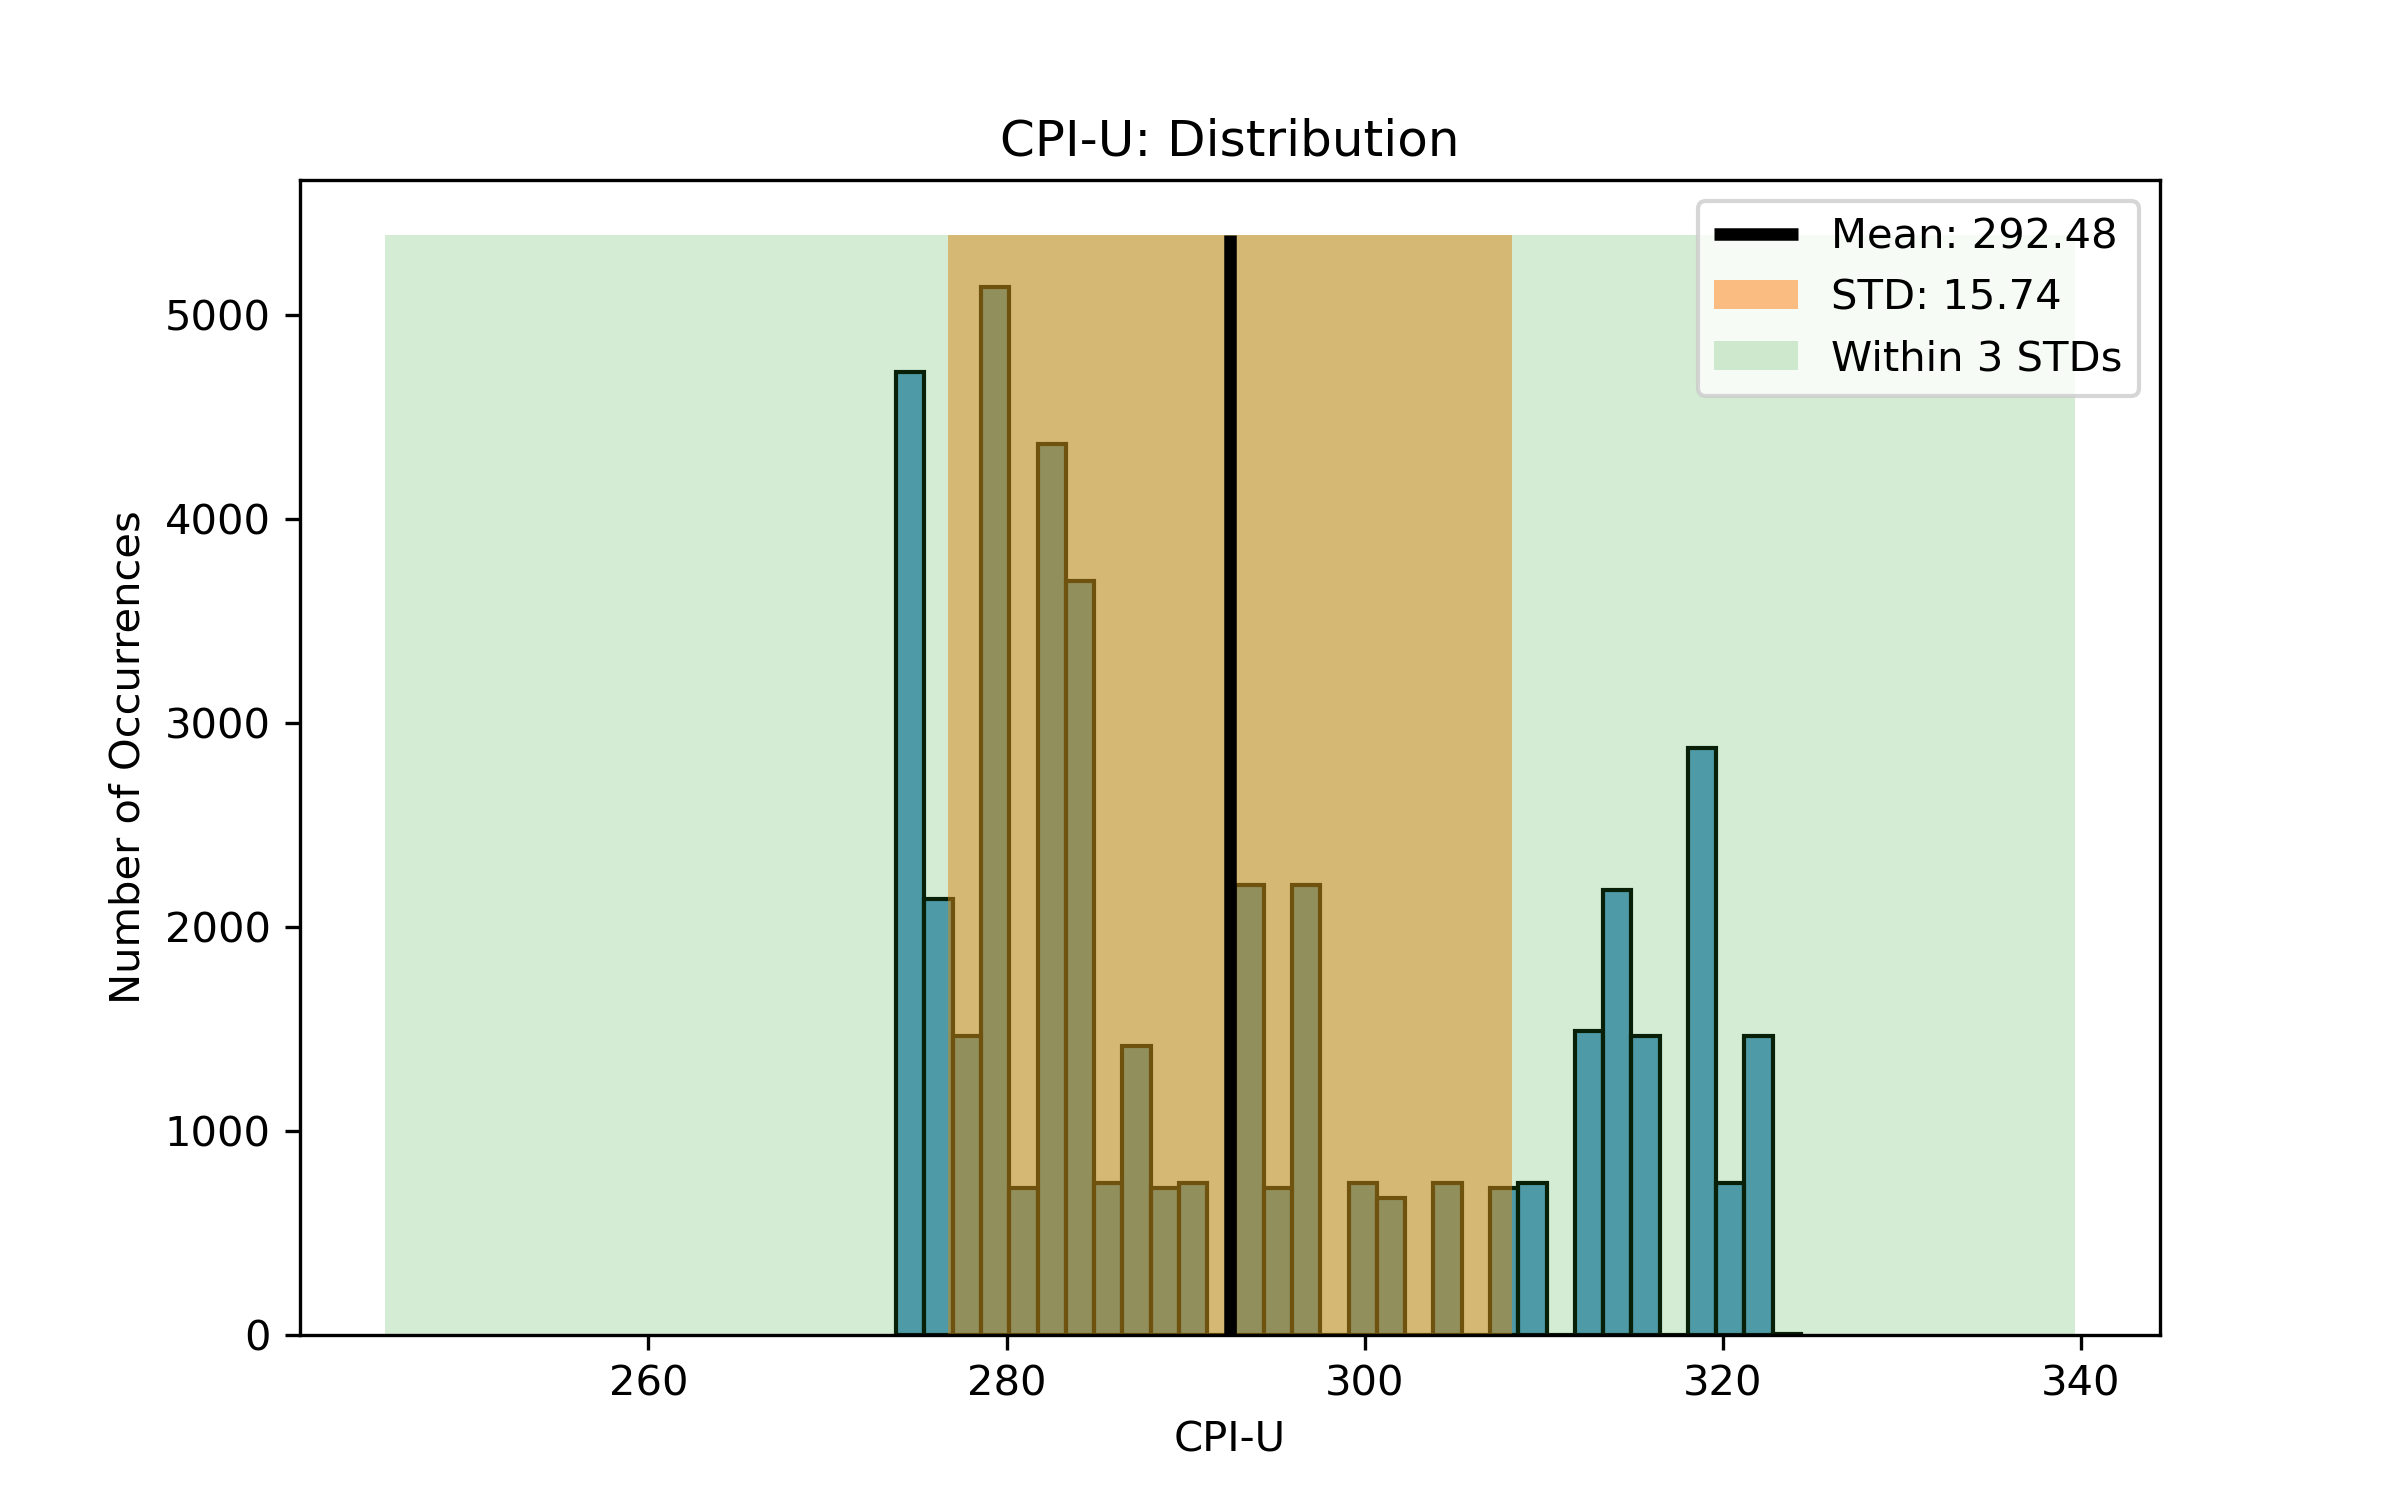

In [151]:
# check that all numerical variables have distribution plots
for variable in preliminary_dataset.columns:
    variable_filename = variable.replace(r"/", "-") # change variable name for file path
    directory = r"Saved/Static Visuals/Distributions"
    filepath = r"{}/{}.png".format(directory, variable_filename)
    if not os.path.isfile(filepath): 
        raise AttributeError("The distribution plot for {} is missing".format(variable))

# load random figure
variable = random.choice([variable.replace(r"/", "-") for variable in preliminary_dataset.columns])
filepath = r"{}/{}.png".format(directory, variable)

# Display the PNG file
Image(filename=filepath, width=750)

<br>

### Load Random Scatterplot

The following code conducts a similar check as above but for scatterplots between every variable included in the processing component of the pipeline and the dependent variable, *Energy Demand (MWH)*.

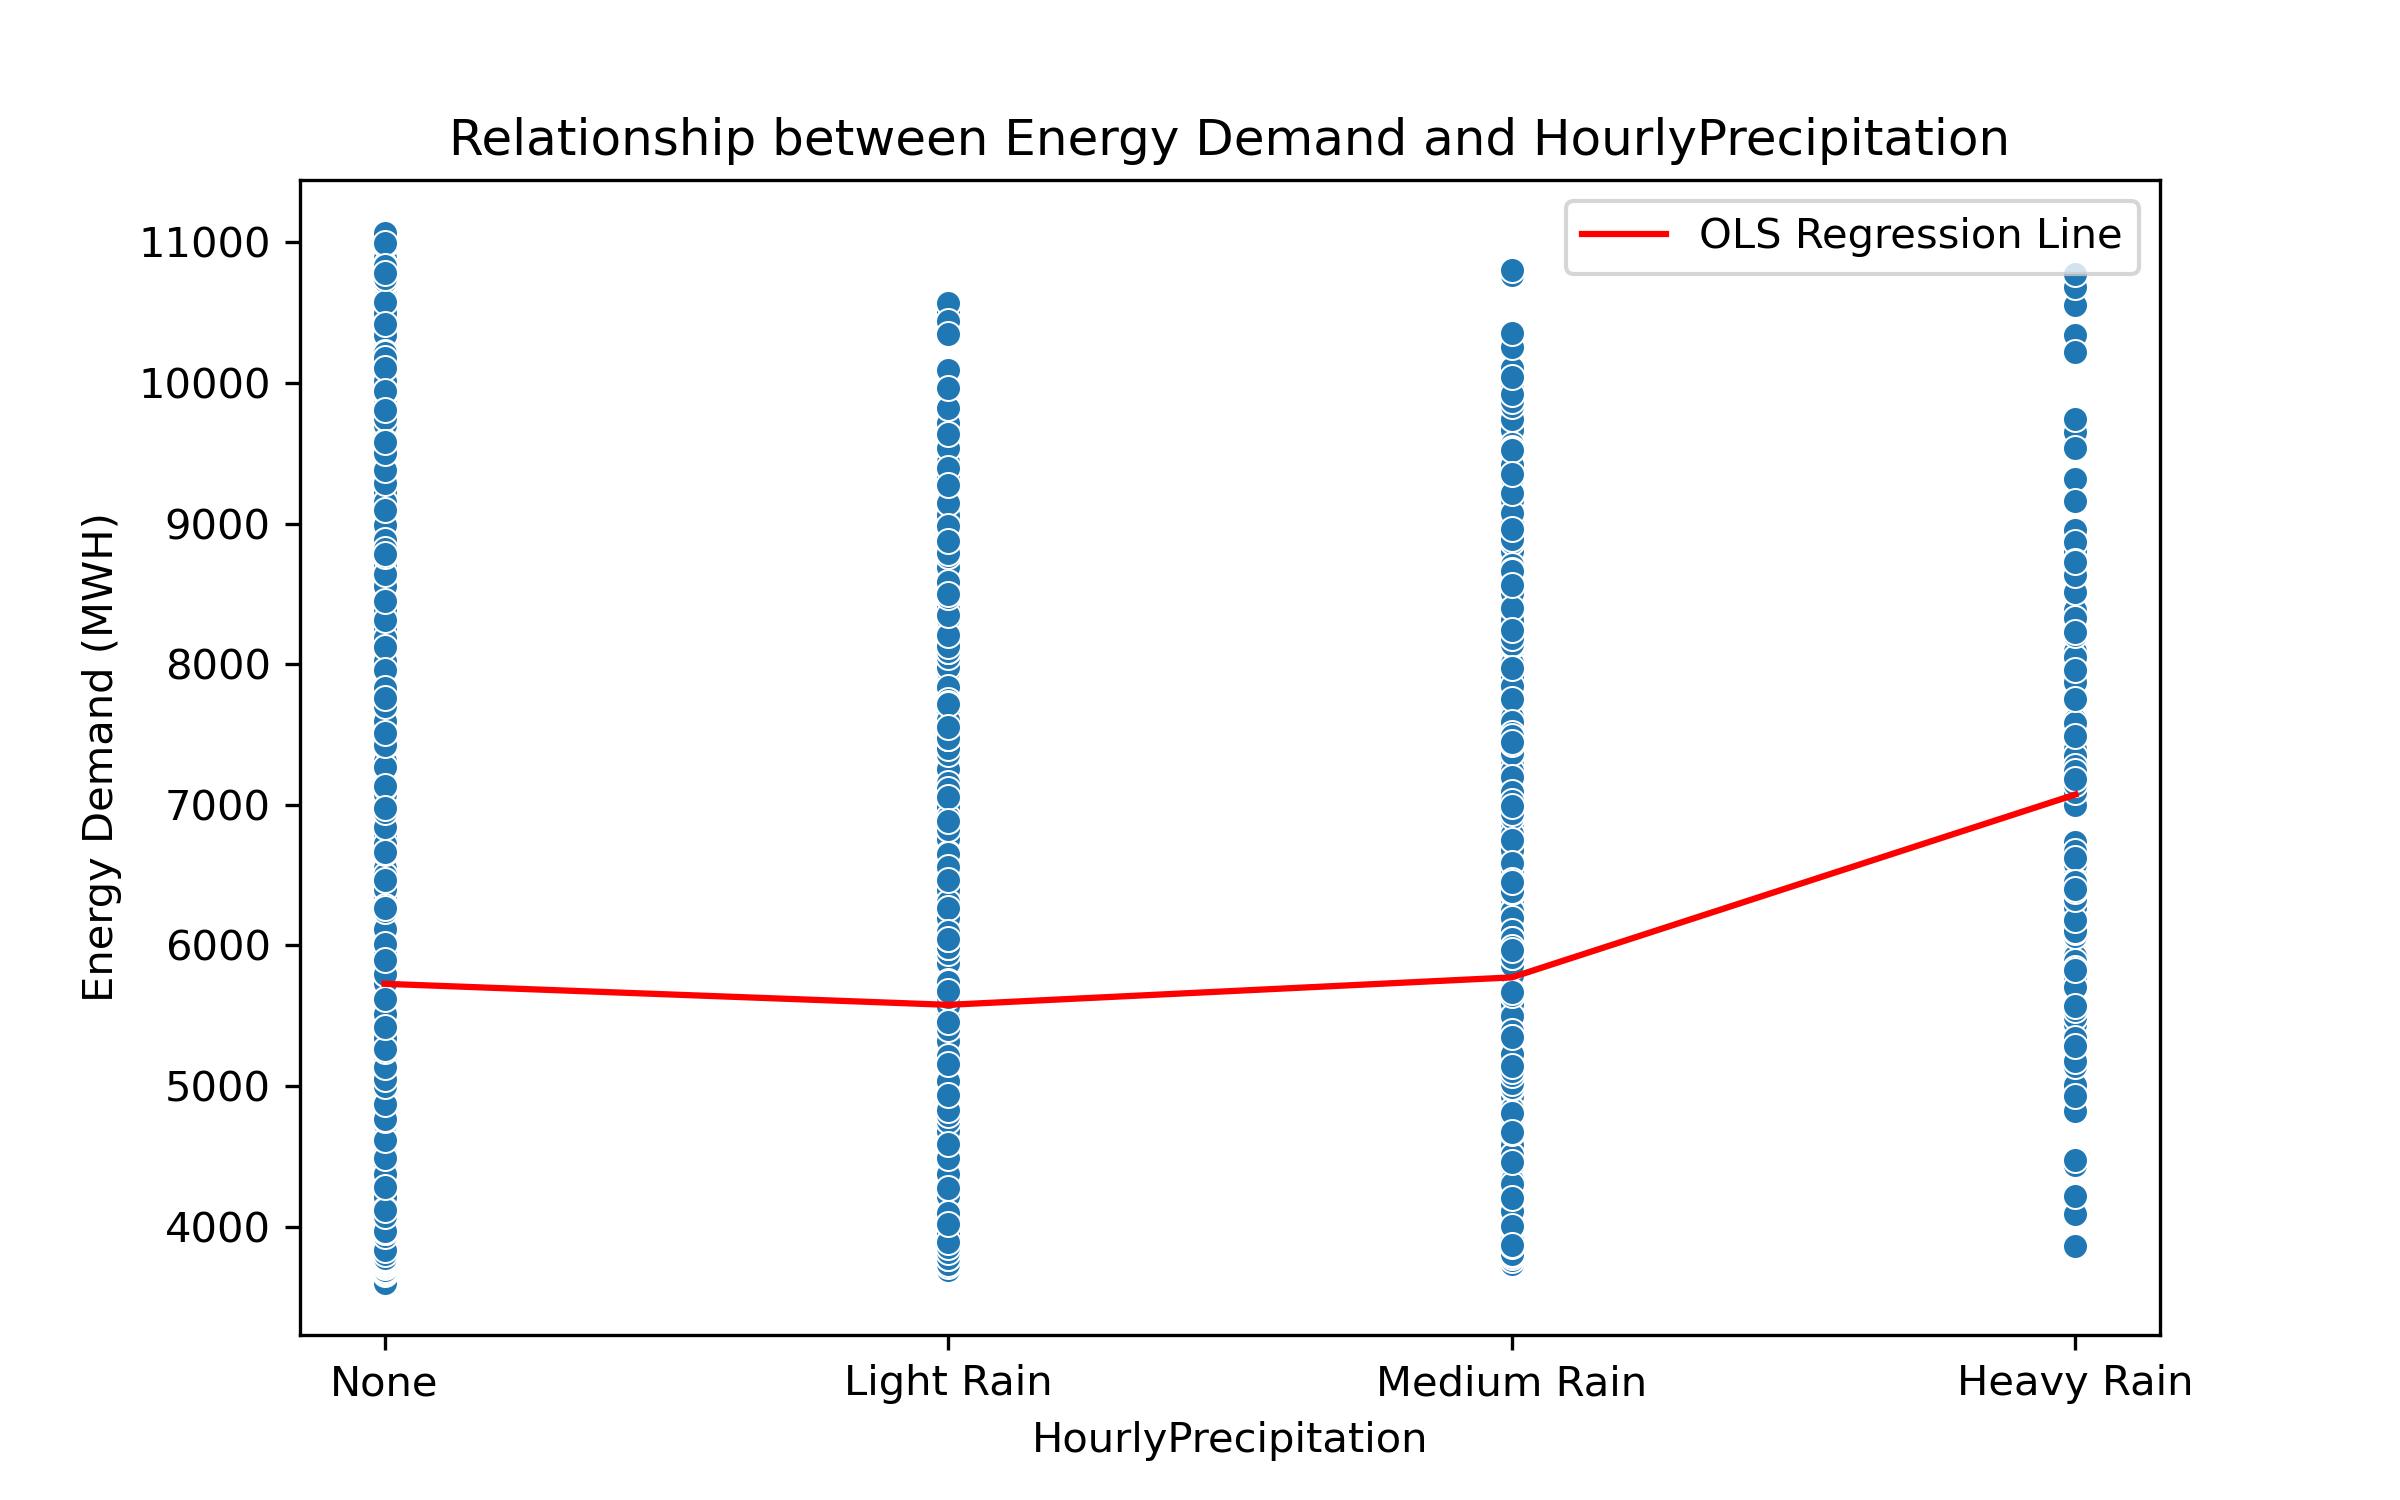

In [150]:
# check that all numerical variables have scatterplots
for variable in preliminary_dataset.columns:
    variable_filename = variable.replace(r"/", "-") # change variable name for file path
    directory = r"Saved/Static Visuals/Scatterplots"
    filepath = r"{}/{}.png".format(directory, variable_filename)
    if not os.path.isfile(filepath): 
        raise AttributeError("The scatterplot for {} is missing".format(variable))

# load random figure
variable = random.choice([variable.replace(r"/", "-") for variable in 
    preliminary_dataset.columns])
filepath = r"{}/{}.png".format(directory, variable)

# Display the PNG file
Image(filename=filepath, width=750)

<br>

### Load Random Time Series Decomposition Plot

Lastly, the following code conducts the same check but for time series decomposition plots for every numerical variable in the processed dataset. These variables correspond to the timer series variables.

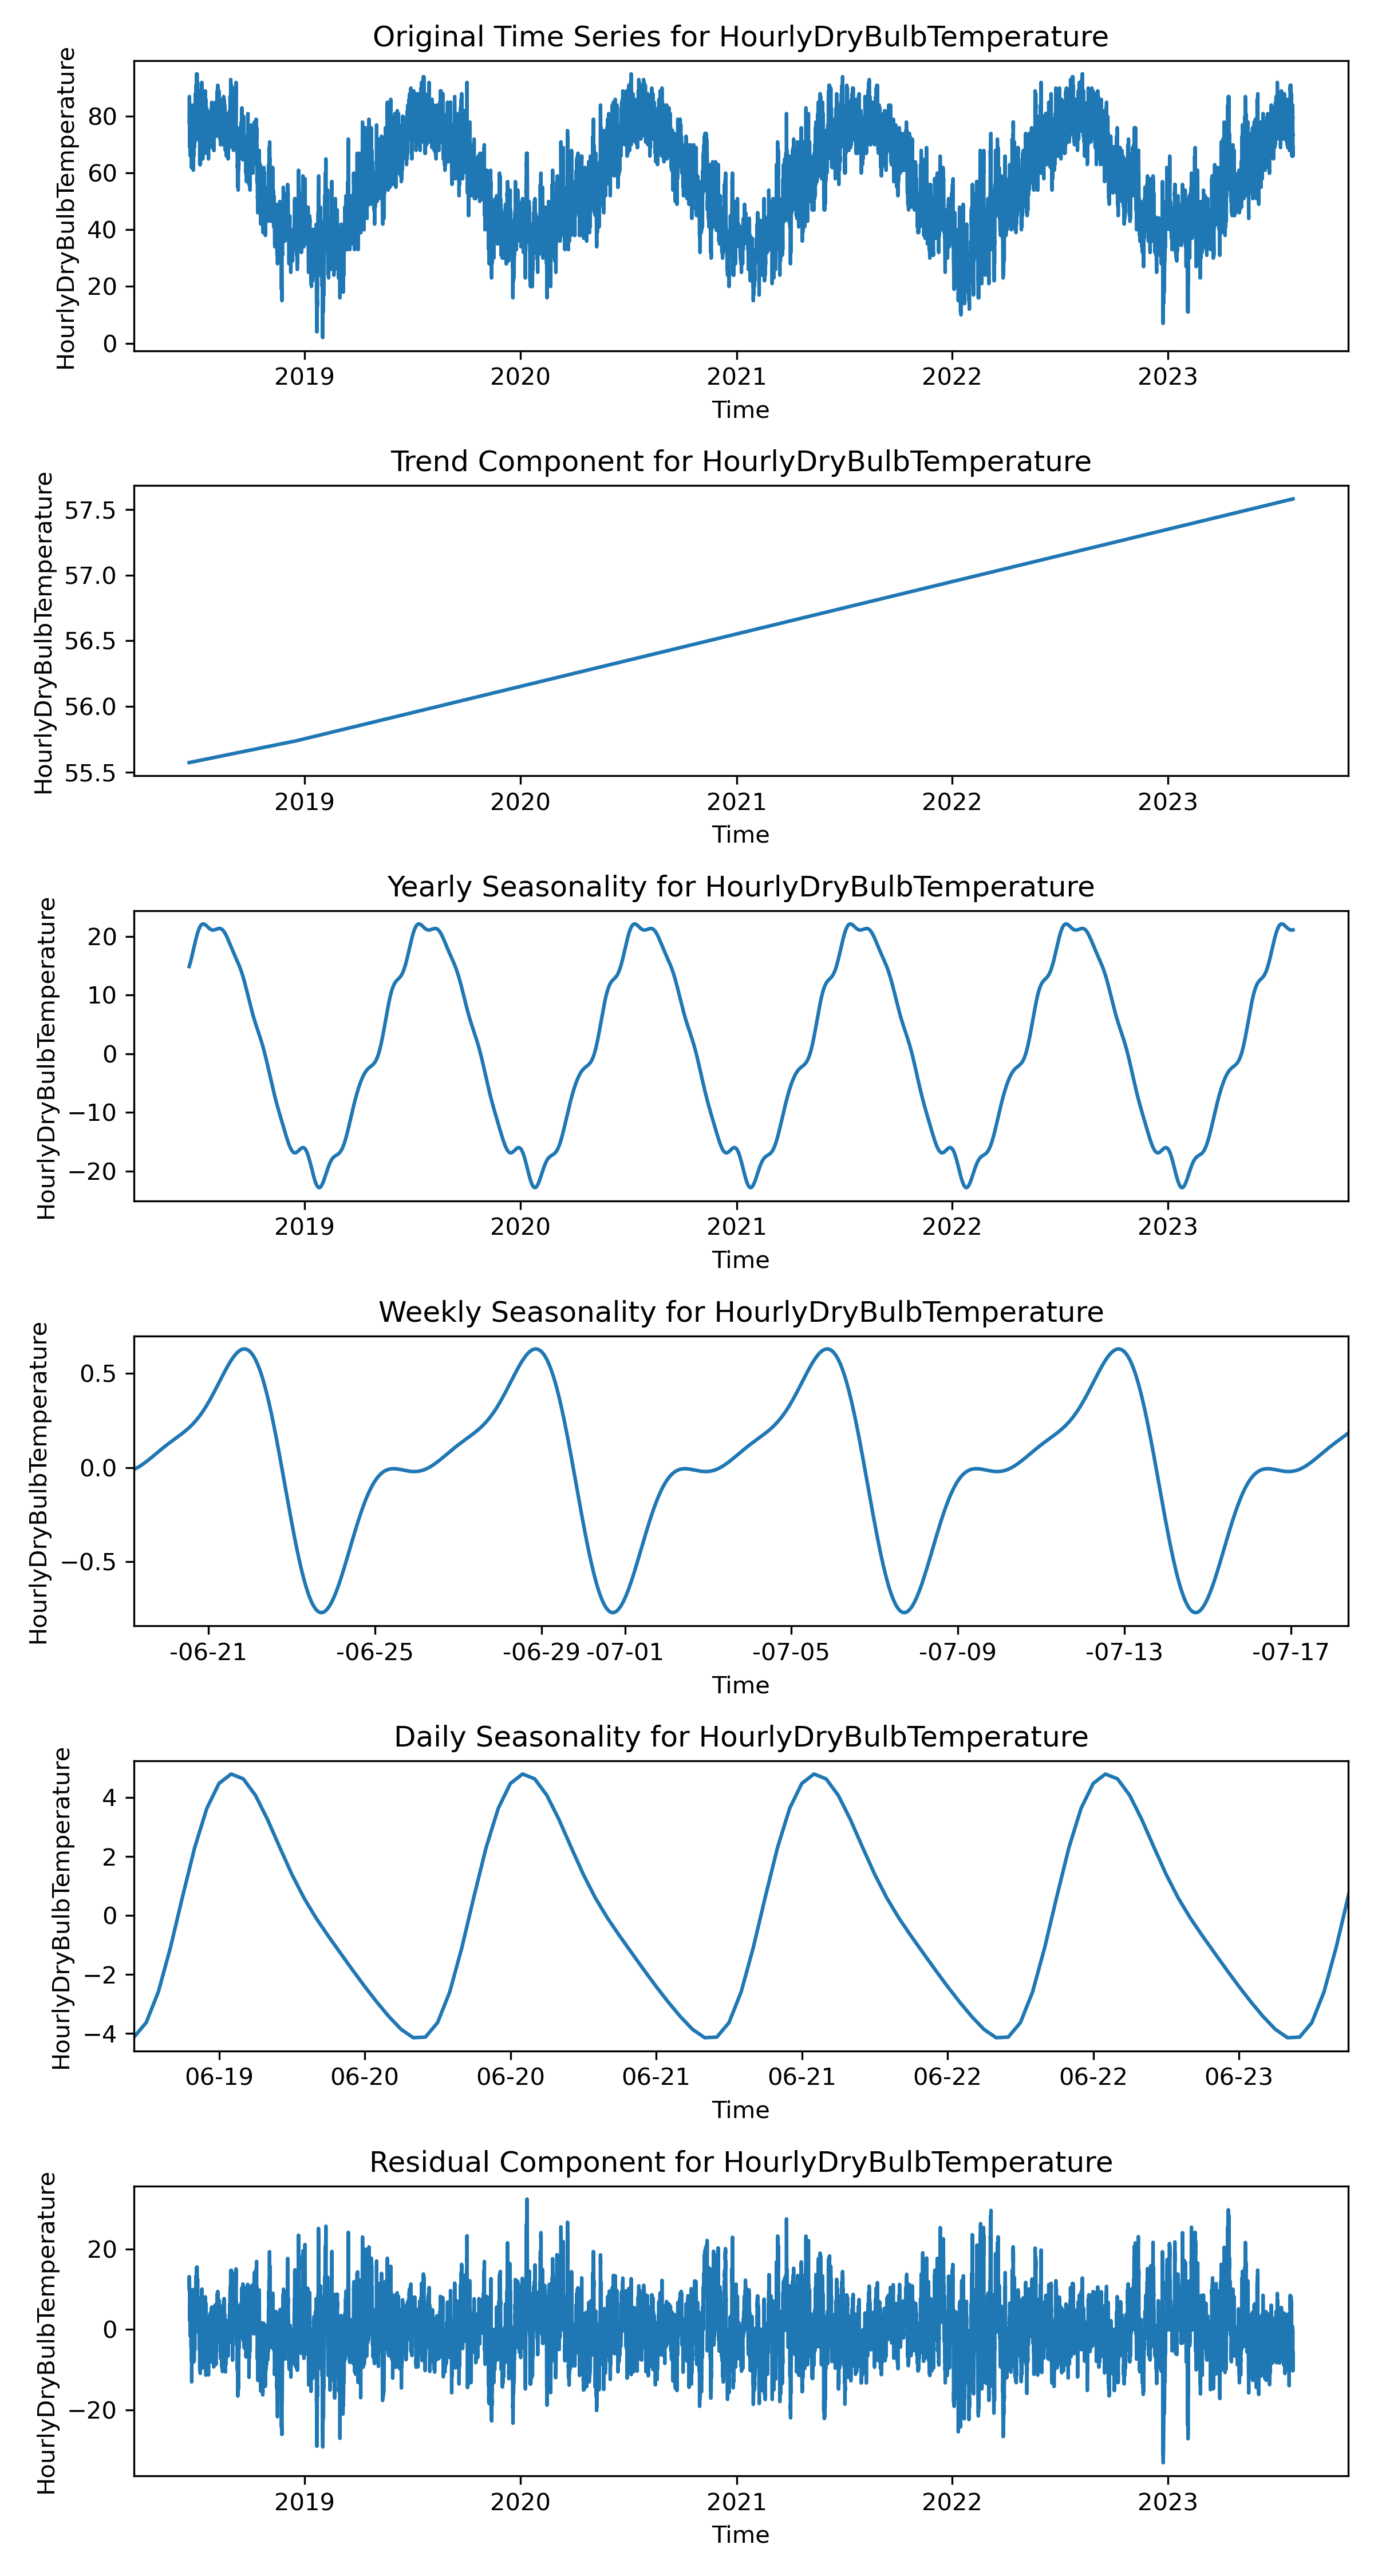

In [152]:
# check that all numerical variables have time series decomposition plots
for variable in clean_training_data.select_dtypes("number").columns:
    variable_filename = variable.replace(r"/", "-") # change variable name for file path
    directory = r"Saved/Static Visuals/Decompositions"
    filepath = r"{}/{}.png".format(directory, variable_filename)
    if not os.path.isfile(filepath): 
        raise AttributeError("The time series decomposition for {} is missing".format(variable))

# load random figure
variable = random.choice([variable.replace(r"/", "-") for variable in 
    clean_training_data.select_dtypes("number")])
filepath = r"{}/{}.png".format(directory, variable)

# Display the PNG file
Image(filename=filepath, width=750)

<br>

# Conclusion

If all of the cells in this notebook are able to run without error, then the data collection, processing, and predictive modeling components of the project are working correctly. While they are designed to work with several specific variables from the EIA, NOAA, and BLS, the *PreProcessingPipeline* and *Forecaster* classes should theoretically be applicable to any other dataset as well. One only need follow the steps outlined in this notebook to integrate the pipeline into their own project.